In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
# Load the uploaded dataset
df = pd.read_csv("/kaggle/input/knn-dataset/Assignment2.csv")

# Assume last column is label
X = df.iloc[:, :-1].values
Y_raw = df.iloc[:, -1].values

# Encode labels (convert strings → 0..4)
encoder = LabelEncoder()
Y = encoder.fit_transform(Y_raw)

num_classes = len(np.unique(Y))
print("Classes:", encoder.classes_)
print("Total samples:", len(X))

Classes: ['Class_1' 'Class_2' 'Class_3' 'Class_4' 'Class_5']
Total samples: 499


In [3]:
def one_hot(y, num_classes):
    oh = np.zeros((len(y), num_classes))
    oh[np.arange(len(y)), y] = 1
    return oh

Y_onehot = one_hot(Y, num_classes)

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y_onehot, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, Y_train.shape)
print("Test:", X_test.shape, Y_test.shape)

Train: (399, 2) (399, 5)
Test: (100, 2) (100, 5)


In [5]:
class ThreeHiddenNN:
    def __init__(self, input_dim, hidden_sizes, output_dim, lr=0.01):
        self.lr = lr
        h1, h2, h3 = hidden_sizes

        self.W1 = np.random.randn(input_dim, h1) * 0.1
        self.b1 = np.zeros((1, h1))

        self.W2 = np.random.randn(h1, h2) * 0.1
        self.b2 = np.zeros((1, h2))

        self.W3 = np.random.randn(h2, h3) * 0.1
        self.b3 = np.zeros((1, h3))

        self.W4 = np.random.randn(h3, output_dim) * 0.1
        self.b4 = np.zeros((1, output_dim))

    def tanh(self, x):
        return np.tanh(x)

    def tanh_deriv(self, x):
        return 1 - np.tanh(x) ** 2

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def forward(self, X):
        self.z1 = X.dot(self.W1) + self.b1
        self.a1 = self.tanh(self.z1)

        self.z2 = self.a1.dot(self.W2) + self.b2
        self.a2 = self.tanh(self.z2)

        self.z3 = self.a2.dot(self.W3) + self.b3
        self.a3 = self.tanh(self.z3)

        self.z4 = self.a3.dot(self.W4) + self.b4
        self.out = self.softmax(self.z4)
        return self.out

    def backward(self, X, Y):
        m = len(X)
        d4 = (self.out - Y) / m

        dW4 = self.a3.T.dot(d4)
        db4 = np.sum(d4, axis=0, keepdims=True)

        d3 = d4.dot(self.W4.T) * self.tanh_deriv(self.z3)
        dW3 = self.a2.T.dot(d3)
        db3 = np.sum(d3, axis=0, keepdims=True)

        d2 = d3.dot(self.W3.T) * self.tanh_deriv(self.z2)
        dW2 = self.a1.T.dot(d2)
        db2 = np.sum(d2, axis=0, keepdims=True)

        d1 = d2.dot(self.W2.T) * self.tanh_deriv(self.z1)
        dW1 = X.T.dot(d1)
        db1 = np.sum(d1, axis=0, keepdims=True)

        self.W4 -= self.lr * dW4
        self.b4 -= self.lr * db4
        self.W3 -= self.lr * dW3
        self.b3 -= self.lr * db3
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1

    def train(self, X, Y, epochs=300):
        losses = []
        for i in range(epochs):
            out = self.forward(X)
            loss = -np.sum(Y * np.log(out + 1e-9)) / len(Y)
            losses.append(loss)
            self.backward(X, Y)

            if i % 50 == 0:
                print(f"Epoch {i}, Loss = {loss:.4f}")

        return losses

    def predict(self, X):
        return np.argmax(self.forward(X), axis=1)

In [6]:
model = ThreeHiddenNN(
    input_dim=X_train.shape[1],
    hidden_sizes=[64, 32, 16],
    output_dim=num_classes,
    lr=0.01
)

losses = model.train(X_train, Y_train, epochs=500)

Epoch 0, Loss = 1.6440
Epoch 50, Loss = 1.5360
Epoch 100, Loss = 1.4675
Epoch 150, Loss = 1.4002
Epoch 200, Loss = 1.3551
Epoch 250, Loss = 1.3229
Epoch 300, Loss = 1.2989
Epoch 350, Loss = 1.2765
Epoch 400, Loss = 1.2769
Epoch 450, Loss = 1.2698


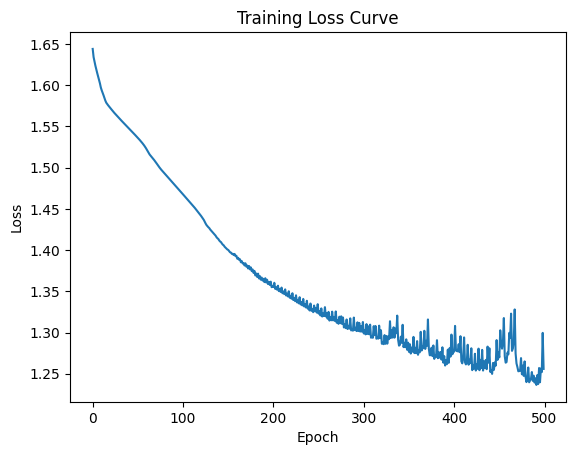

In [7]:
plt.plot(losses)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [8]:
Y_pred = model.predict(X_test)
Y_true = np.argmax(Y_test, axis=1)

accuracy = np.mean(Y_pred == Y_true)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.5


[[14  1  1  0  1]
 [ 5  8  2  1 10]
 [ 0  1  5  0 14]
 [ 0  0  1  2 13]
 [ 0  0  0  0 21]]


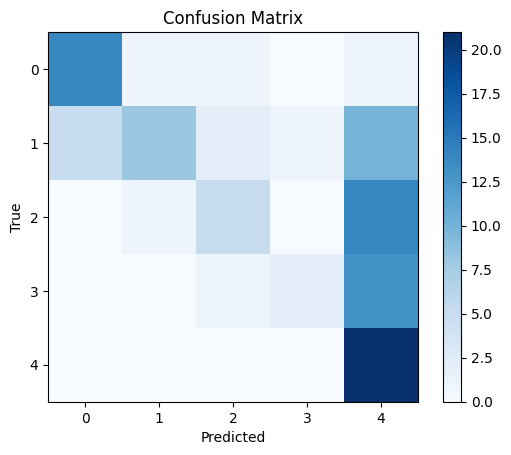

In [9]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_true, Y_pred)
print(cm)

plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [10]:
from sklearn.metrics import classification_report

print(classification_report(Y_true, Y_pred, target_names=encoder.classes_))  

              precision    recall  f1-score   support

     Class_1       0.74      0.82      0.78        17
     Class_2       0.80      0.31      0.44        26
     Class_3       0.56      0.25      0.34        20
     Class_4       0.67      0.12      0.21        16
     Class_5       0.36      1.00      0.53        21

    accuracy                           0.50       100
   macro avg       0.62      0.50      0.46       100
weighted avg       0.63      0.50      0.46       100

